In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.interpolate import griddata

Lbox = 100.
gauss_sm = 3.
nbin_in = 512
dx_in = Lbox/nbin_in

nbins = 200
dx = 0.5
#0.5Mpc/h bins
sm_tmp = np.sqrt(gauss_sm**2 - dx**2)

flux_nyx_fil = '/Users/kheegan/lya/3d_recon/preheating/nyx_mock_clamato.bin'

f_nyx = np.fromfile(flux_nyx_fil)
f_nyx = np.reshape(f_nyx, (nbins, nbins, nbins))
f_nyx = ndimage.gaussian_filter(f_nyx, sm_tmp/dx, mode='wrap')

dm_nyx_fil = '/Users/kheegan/lya/3d_recon/preheating/nyx1000_512.npy'
dm_nyx_in = np.load(dm_nyx_fil)

dm_nyx_sm = ndimage.gaussian_filter(dm_nyx_in, gauss_sm/dx_in, mode='wrap')
dm_nyx = ndimage.zoom(dm_nyx_sm, nbins/nbin_in)

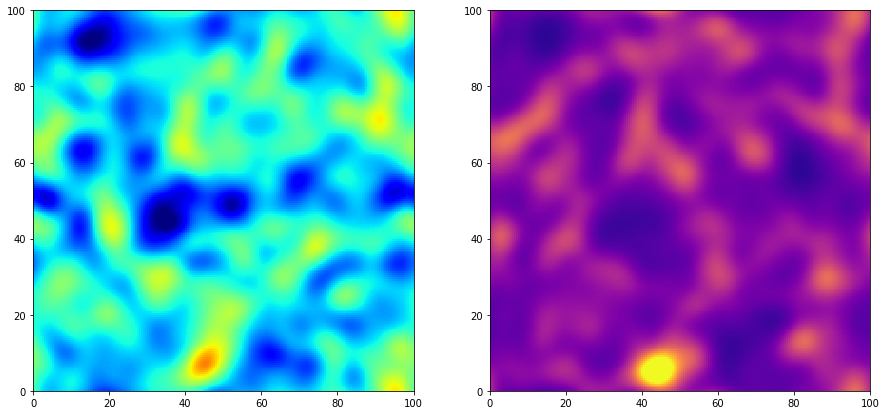

In [2]:
zcut2 = 126

fslice = f_nyx[:,:,zcut2]
dslice = dm_nyx[:,:, zcut2]
xbinsn = np.linspace(0, Lbox, num=201)
ybinsn = np.linspace(0, Lbox, num=201)

X, Y = np.meshgrid(xbinsn, ybinsn)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

ax1.pcolormesh(X, Y, fslice, cmap='jet_r', vmin=-0.3, vmax=0.2)
ax1.set_aspect('equal')

ax2.pcolormesh(X, Y, dslice, cmap='plasma', vmin=0.3, vmax=2.5)
ax2.set_aspect('equal')

plt.show()

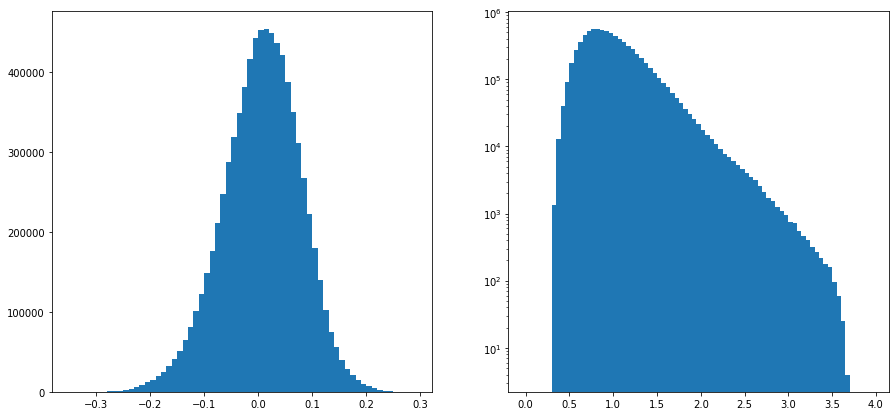

In [3]:
# plot 1D histograms for flux and density

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

ax1.hist(np.ndarray.flatten(f_nyx), bins=np.arange(-0.35, 0.3, 0.01))
ax2.hist(np.ndarray.flatten(dm_nyx), bins=np.arange(0., 4., 0.05), log=True)
plt.show()

In [4]:
# compute and plot 2d histogram
bins_f = np.arange(-0.35,0.3, 0.01)
bins_dm = np.arange(0., 4., 0.05)

hist2d_nyx, edges_dm, edges_f = np.histogram2d(np.ndarray.flatten(dm_nyx), np.ndarray.flatten(f_nyx), 
                            bins=[bins_dm, bins_f],density=True)

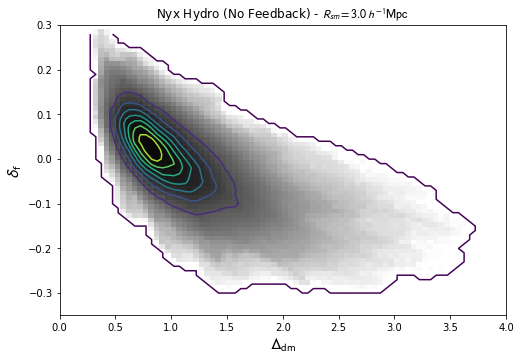

In [5]:
X, Y = np.meshgrid(edges_dm,  edges_f)
XCon, YCon = np.meshgrid(edges_dm[0:-1]+(edges_dm[1]-edges_dm[0])/2 , 
                         edges_f[0:-1]+(edges_f[1]-edges_f[1])/2 )

fig, ax = plt.subplots(figsize=(8,7))

ax.pcolormesh(X,Y, np.transpose(hist2d_nyx), cmap='Greys',
              norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))

ax.set_xlim(0., 4.)
ax.set_ylim(-0.35,0.3)
ax.set_xlabel(r'$\Delta_\mathrm{dm}$', fontsize=16)
ax.set_ylabel(r'$\delta_\mathrm{f}$', fontsize=16)
ax.set_aspect(4.)
smtext = r'$R_{sm} = '+'{}'.format(gauss_sm)+'\, h^{-1}\mathrm{Mpc}$'
ax.set_title('Nyx Hydro (No Feedback) - '+smtext)

ax.contour(XCon,YCon, np.transpose(hist2d_nyx))

plt.show()

Here we test recreating the same plot with the 2Mpc/h binned DM field. This is analogous to how we would operate on the actual BIRTH reconstructions that have 1.875Mpc/h binning. 

We basically have to interpolate off the coarse DM grid cells (which had already had smoothing implemented in the first step, but coarse binning) to set up the flux-density relationship. 

In [6]:

# Rebin Nyx DM field to 2Mpc/h bins
nbincoarse = 50
dx_c = 2.
#sm_tmp = np.sqrt(gauss_sm**2 - dx_c**2)
dm_coarse = ndimage.zoom(dm_nyx_sm, nbincoarse/nbin_in)
#dm_coarse = ndimage.gaussian_filter(dm_coarse, gauss_sm/dx_c, mode='wrap' )

In [7]:
xcen = xbinsn[0:-1]+(xbinsn[1]-xbinsn[0])/2.
ycen = ybinsn[0:-1]+(ybinsn[1]-ybinsn[0])/2.
zcen = np.copy(ycen)

xgdm = np.linspace(0.,Lbox, 51)
dx_c = (xgdm[1]- xgdm[0])/2.
xgdm = xgdm[0:-1] + dx_c
ygdm = np.linspace(0.,100, 51)
ygdm = ygdm[0:-1] + dx_c
zgdm = np.linspace(0.,100, 51)
zgdm = zgdm[0:-1] + dx_c

ix2c = (xcen - xgdm[0])/dx_c*dx
iy2c = (ycen - ygdm[0])/dx_c*dx
iz2c = (zcen - ygdm[0])/dx_c*dx

xgfine, ygfine, zgfine = np.meshgrid(ix2c, iy2c, iz2c)

#i_off = np.arange(0,200) + 0.25
#xtmp, ytmp, ztmp = np.meshgrid(i_off, i_off, i_off)

#ind3d_fine = [xtmp.flatten(), ytmp.flatten(), ztmp.flatten()]
ind3d_fine = [xgfine.flatten(), ygfine.flatten(), zgfine.flatten()]

dm_int_arr = ndimage.map_coordinates(dm_coarse, ind3d_fine, order=1,
                                                  mode='wrap').reshape([nbins, nbins, nbins])

dm_int_arr = np.transpose(dm_int_arr, (1,0,2))

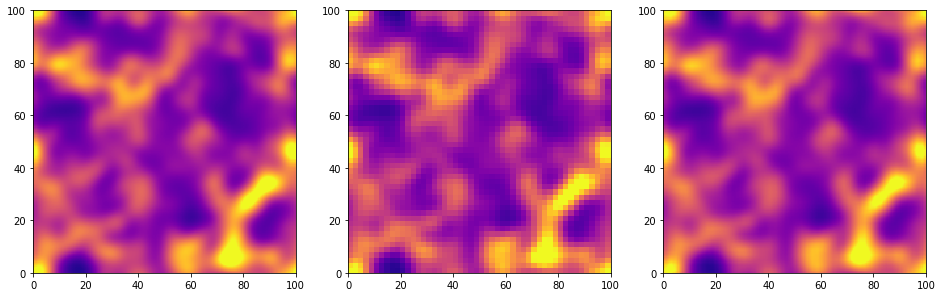

In [8]:

zcut1 = 72
zcut2 = int(np.round(zcut1/4.))

dslice1 = dm_nyx[:,:,zcut1]
dslice2 = dm_int_arr[:,:,zcut1]
xbins1 = np.linspace(0, 100, num=201)
ybins1 = np.linspace(0, 100, num=201)

X1, Y1 = np.meshgrid(xbins1, ybins1)
X2, Y2 = np.meshgrid(np.linspace(0,100,num=51), np.linspace(0,100,num=51))
Xin, Yin = np.meshgrid(np.linspace(0,100,num=513), np.linspace(0,100,num=513))

fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(16,5))

ax1.pcolormesh(X1, Y1, dslice1, cmap='plasma', vmin=0.3, vmax=2)
ax1.set_aspect('equal')

ax2.pcolormesh(X2, Y2, dm_coarse[:,:,zcut2], cmap='plasma', vmin=0.3, vmax=2)
ax2.set_aspect('equal')

ax3.pcolormesh(X1, Y1, dslice2, cmap='plasma', vmin=0.3, vmax=2)
ax3.set_aspect('equal')

plt.show()

hist2d_coarse, edges_dm2, edges_f2 = np.histogram2d(dm_interpolated, 
                                                    np.ndarray.flatten(f_nyx), 
                            bins=[bins_dm, bins_f],density=True)

X, Y = np.meshgrid(edges_dm2,  edges_f2)
XCon, YCon = np.meshgrid(edges_dm2[0:-1]+(edges_dm2[1]-edges_dm2[0])/2 , 
                         edges_f2[0:-1]+(edges_f2[1]-edges_f2[1])/2 )

fig, ax = plt.subplots(figsize=(8,7))

ax.pcolormesh(X,Y, np.transpose(hist2d_coarse), cmap='Greys',
              norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))

ax.set_xlim(0., 4.)
ax.set_ylim(-0.35,0.3)
ax.set_xlabel(r'$\delta_\mathrm{dm}$', fontsize=16)
ax.set_ylabel(r'$\delta_\mathrm{f}$', fontsize=16)
ax.set_aspect(4.)
ax.set_title('Nyx Hydro (No Feedback) - Interpolated')

ax.contour(XCon,YCon, np.transpose(hist2d_coarse))

plt.show()

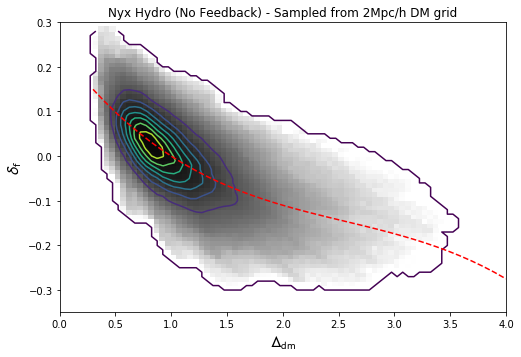

In [9]:
hist2d_int, edges_dm, edges_f = np.histogram2d(np.ndarray.flatten(dm_int_arr), np.ndarray.flatten(f_nyx), 
                            bins=[bins_dm, bins_f],density=True)

fig, ax = plt.subplots(figsize=(8,7))

ax.pcolormesh(X,Y, np.transpose(hist2d_int), cmap='Greys',
              norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))

ax.set_xlim(0., 4.)
ax.set_ylim(-0.35,0.3)
ax.set_xlabel(r'$\Delta_\mathrm{dm}$', fontsize=16)
ax.set_ylabel(r'$\delta_\mathrm{f}$', fontsize=16)
ax.set_aspect(4.)
ax.set_title('Nyx Hydro (No Feedback) - Sampled from 2Mpc/h DM grid')

ax.contour(XCon,YCon, np.transpose(hist2d_int))

# Fit polynomial to distribution
dmflat = dm_int_arr.flatten()
f_flat = f_nyx.flatten()

lowden = dmflat<1.5 # np.logical_and(dmflat < 1.5, dmflat>0.5)
ppar = np.polyfit(dmflat[lowden],f_flat[lowden] ,3)

dmgrid = np.linspace(0.3,4., 37)
f_poly = ppar[0]*dmgrid**3 + ppar[1]*dmgrid**2 + ppar[2]*dmgrid + ppar[3]

ax.plot(dmgrid, f_poly, color='red', linestyle='dashed')

plt.show()

In [10]:
from scipy.stats import pearsonr

print(pearsonr(np.ndarray.flatten(dm_nyx), np.ndarray.flatten(f_nyx)))

(-0.6784821343626182, 0.0)


In [11]:
print(ppar)

[-0.01393305  0.10678557 -0.33299407  0.2402709 ]
